In [1]:
!nvidia-smi

Mon Dec 21 09:40:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000001:00:00.0 Off |                    0 |
| N/A   64C    P0    60W / 149W |   8350MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense,Embedding, Concatenate, TimeDistributed, Attention,Bidirectional
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from attention import AttentionLayer
import pickle as pkl
import numpy as np
from unidecode import unidecode
import nltk
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu, corpus_bleu
from nltk.translate.nist_score import sentence_nist, corpus_nist
from nltk.translate.meteor_score import meteor_score
import sys
nltk.download('wordnet')
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
import matplotlib.ticker as ticker
from wordcloud import WordCloud

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#tomada de tempo de excução
runStart = datetime.now()

In [4]:
#
# MODO DE EXECUÇÃO DO NOTEBOOK
#
# Para evitar consumo de máquina e tempo este notebook pode ser executado de duas formas.
#
# False = usa pesos e outros parâmetros salvos. Não roda otimizações, usa do modelo
#       ja salvo, mas roda cálculos e gráficos.
#
# True = roda o notebook inteiro: todas otimizações, cálculos e gráficos.
#
#
RUN_MODE = False

In [5]:
#Importação do CORPUS no mesmo diz local no formato tsv
b2wCorpus = pd.read_csv('b2wCorpusFull.tsv',"\t",usecols=['review_title','review_text'], encoding='utf-8') #,nrows=10000)
b2wCorpus = b2wCorpus.rename(columns={'review_title': 'title', 'review_text': 'review'})
b2wCorpus.head()

,title,review
0,bom,estou contente com a compra entrega rápida o ú...
1,"preço imbatível, ótima qualidade","por apenas r$1994.20,eu consegui comprar esse ..."
2,atende todas as expectativa.,supera em agilidade e praticidade outras panel...
3,presente mais que desejado,meu filho amou! parece de verdade com tantos d...
4,"sem duvidas, excelente","a entrega foi no prazo, as americanas estão de..."


In [6]:
# Pré-processamento
def cleanning(text, stem=False):
  text = text.replace("@"," ")
  text = re.sub('[*)@#%(&$_^~]', '', text)
  text = re.sub(r'([?!.])\1+', r'\1', text)
  text = re.sub(r"([?.!,¿])", r" \1 ", text)
  text = re.sub(r'[" "]+', " ", text)
  text = re.sub("\d+", "", text).strip()
  return text

In [7]:
b2wCorpus.review = b2wCorpus.review.apply(lambda x: cleanning(x))
b2wCorpus.title = b2wCorpus.title.apply(lambda x: cleanning(x))
b2wCorpus.drop_duplicates(subset=['review'], inplace=True)
b2wCorpus.dropna(axis=0,inplace=True)
b2wCorpus.shape

(129601, 2)

In [8]:
# Recorte do corpus baseado no max_length_review e no max_length_title
max_length_review = 60
max_length_title = 10
def tamanho(text):
    return len(text.split())
b2wCorpus = b2wCorpus[b2wCorpus['review'].apply(tamanho) > 3]
b2wCorpus = b2wCorpus[b2wCorpus['review'].apply(tamanho) <= max_length_review]
b2wCorpus = b2wCorpus[b2wCorpus['title'].apply(tamanho) > 0 ]
b2wCorpus = b2wCorpus[b2wCorpus['title'].apply(tamanho) <= max_length_title]

In [9]:
b2wCorpus.shape

(116780, 2)

In [10]:
b2wCorpus.head()

,title,review
0,bom,estou contente com a compra entrega rápida o ú...
1,"preço imbatível , ótima qualidade","por apenas r . , eu consegui comprar esse lin..."
2,atende todas as expectativa .,supera em agilidade e praticidade outras panel...
3,presente mais que desejado,meu filho amou ! parece de verdade com tantos ...
4,"sem duvidas , excelente","a entrega foi no prazo , as americanas estão d..."


In [11]:
# Inserção das tags de <start> e <end> no title
def start_end(itext):
    text = "<start> " + itext + " <end>"
    return text
b2wCorpus.title = b2wCorpus.title.apply(lambda x: start_end(x))

In [12]:
# Atualizando do index e suffling do dataframe do corpus
b2wCorpus=b2wCorpus.sample(frac=1).reset_index(drop=True)

In [13]:
# Print de amostra do titulo e do review
review_text_ = b2wCorpus['review'].values
title_text_ = b2wCorpus['title'].values
for j in range(9):
    print("\n\ntitle: " + title_text_[j])
    print("\nreview: " +  review_text_[j])



title: <start> excelente <end>

review: excelente produto para sala razoavelmente grande , rápido na entrega .


title: <start> otimo produto <end>

review: comprei , chegou  dias antes do prazo e eu amei a digital é super rápida e ele é muito lindo


title: <start> nota <end>

review: excelente produto ! recomendo a todos ! tem várias opções de cores e modelos .


title: <start> ótimo <end>

review: forma grande porém a blusa é de ótima qualidade . super linda !


title: <start> muito boa <end>

review: por enquanto estou gostando muitooo . espero que continue assim


title: <start> gostei <end>

review: o capacete é simples mai vale muito a pena pelo preço


title: <start> produto bom ! <end>

review: atende as necessidades deixa o acabamento diferenciado . mas nada que o couro original !


title: <start> produto bom <end>

review: produto bom só a entrega que não foi feita na data que a empresa directstock definiu não foi cumprida houve atraso e não recomendo a empresa directstock

In [14]:
# Função de split de dados
def train_validate_test_split(df, train_percent=.70, validate_percent=.15, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

b2wCorpusTrain, b2wCorpusValidate, b2wCorpusTest = train_validate_test_split(b2wCorpus)

In [15]:
# Split
b2wCorpusTrain, b2wCorpusValidate, b2wCorpusTest = train_validate_test_split(b2wCorpus)

# Criação das séries
# Treino, Validação e Teste
X_train =  b2wCorpusTrain.review.values.tolist()
y_train =  b2wCorpusTrain.title.values.tolist()

X_val = b2wCorpusValidate.review.values.tolist()
y_val = b2wCorpusValidate.title.values.tolist()

X_test = b2wCorpusTest.review.values.tolist()
y_test = b2wCorpusTest.title.values.tolist()

len(X_train),len(X_val), len(X_test)


(81746, 17517, 17517)

In [16]:
# Print de amostra do X e y
X_train[10], y_train[10]

('o produto não funciona como a propaganda exibe , coloquei o chip como indicado mas não funcionou , não indico , não funciona !',
 '<start> não funcionou <end>')

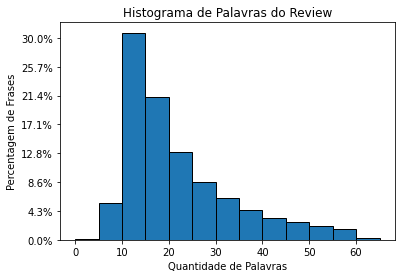

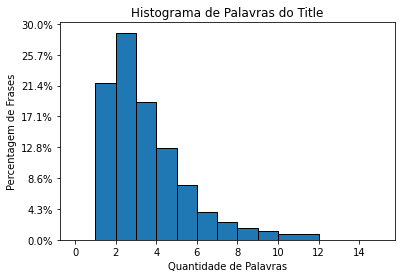

In [17]:
# Histograma de palavras no titulo e no teview
def histA():
    aReview = []
    aTitle = []
    size = len(b2wCorpus.index)
    for i in range(size):
        aTitle.append(len(b2wCorpus.iloc[i].title.split())-2)
        aReview.append(len(b2wCorpus.iloc[i].review.split()))
    return aTitle, aReview
aTitle, aReview = histA()
num_of_points = len(aReview)
data = aReview
fig, ax = plt.subplots()
ax.hist(data, bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65], edgecolor='black')
ax.set_title("Histograma de Palavras do Review")
ax.set_xlabel("Quantidade de Palavras")
ax.set_ylabel("Percentagem de Frases")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(data)))
plt.show()
num_of_points = len(aTitle)
num_of_bins = 20 
data = aTitle
fig, ax = plt.subplots()
ax.hist(data, bins=[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15], edgecolor='black')
ax.set_title("Histograma de Palavras do Title")
ax.set_xlabel("Quantidade de Palavras")
ax.set_ylabel("Percentagem de Frases")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(data)))
plt.show()

In [18]:
# Ajueste do tamanho do y após tags de <start> e <end>
max_length_title = 12

In [19]:
# Checagem do tamanho de train, val e test
len(X_train),len(X_val), len(X_test)

(81746, 17517, 17517)

In [20]:
# Tokenização dos Xs
reviewTokenizer = Tokenizer()
reviewTokenizer.fit_on_texts(X_train)
Eword2index = reviewTokenizer.word_index
vocab_size_source = len(Eword2index) + 1

X_train = reviewTokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length_review, padding='post')

X_val = reviewTokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, maxlen = max_length_review, padding='post')

X_test = reviewTokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length_review, padding='post')

In [21]:
# Tokenização dos ys
titleTokenizer = Tokenizer()
titleTokenizer.fit_on_texts(y_train)
Mword2index = titleTokenizer.word_index
vocab_size_target = len(Mword2index) + 1

y_train = titleTokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_length_title, padding='post')

y_val = titleTokenizer.texts_to_sequences(y_val)
y_val = pad_sequences(y_val, maxlen = max_length_title, padding='post')

y_test = titleTokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen = max_length_title, padding='post')

In [22]:
# Checagem dos tamanhos dos dicionários
vocab_size_source, vocab_size_target

(34529, 10405)

In [23]:
# Persistindo a train e val
with open('NMT_data.pkl','wb') as f:
  pkl.dump([X_train, y_train, X_val, y_val],f)


In [24]:
with open('NMT_Etokenizer.pkl','wb') as f:
  pkl.dump([vocab_size_source, Eword2index, reviewTokenizer], f)

with open('NMT_Mtokenizer.pkl', 'wb') as f:
  pkl.dump([vocab_size_target, Mword2index, titleTokenizer], f)

In [25]:
# Checagem da tokenização
X_train[0], y_train[0], y_test[0]

(array([   48,     9,     4,   561,   688,     8,   221,    37,   453,
          169,     9,    13,    25,     5,  1403,   107,     2,   443,
          778,     1,  3905,    49,  1635,  1025,     3,   443, 12676,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0], dtype=int32),
 array([1, 8, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([1, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32))

In [26]:
# Garantindo que as series estão em np.array
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [27]:
X_train[0], y_train[0], y_test[0]

(array([   48,     9,     4,   561,   688,     8,   221,    37,   453,
          169,     9,    13,    25,     5,  1403,   107,     2,   443,
          778,     1,  3905,    49,  1635,  1025,     3,   443, 12676,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0], dtype=int32),
 array([1, 8, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([1, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32))

In [28]:
# Definindo hiper-parâmetros
latent_dim_bi = 32
latent_dim = 64
epochs = 20
batch_size = 256
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [29]:
# Rede: arquitetura, configurações, parâmetros e otimização
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
with tf.device('GPU:0'):
    from keras import backend as K 
    K.clear_session() 
    # Encoder 
    encoder_inputs = Input(shape=(max_length_review,)) 
    enc_emb = Embedding(vocab_size_source, latent_dim,trainable=True)(encoder_inputs) 

    # Bidirectional
    forward_layer = LSTM(latent_dim_bi, return_state=True, return_sequences=True) 
    backward_layer = LSTM(latent_dim_bi, return_state=True, return_sequences=True, go_backwards=True)
    encoder_bilstm3 = Bidirectional(forward_layer, backward_layer=backward_layer)
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bilstm3(enc_emb)
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
                            
    # LSTM 1 
    encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
    encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

    # LSTM 2 
    encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
    encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

    # LSTM 3 
    encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
    encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

    # Decoder
    decoder_inputs = Input(shape=(None,)) 
    dec_emb_layer = Embedding(vocab_size_target, latent_dim,trainable=True) 
    dec_emb = dec_emb_layer(decoder_inputs) 

    # LSTM usando encoder_states como initial state
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
    decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

    # Attention Layer
    attn_layer = AttentionLayer(name='attention_layer') 
    attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

    # Concatenação do attention output e o decoder LSTM output 
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

    # Dense layer
    decoder_dense = TimeDistributed(Dense(vocab_size_target, activation='softmax')) 
    decoder_outputs = decoder_dense(decoder_concat_input) 

    # Definição da model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
    model.summary()
    plot_model(model, to_file='NMT_EP3_1-002_train_model.png', show_shapes=True)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
    
    if RUN_MODE:
        history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:], 
                            epochs=epochs, 
                            callbacks=[es],
                            batch_size=batch_size,
                            validation_data = ([X_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))
        with open('NMT_history.history', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
    else:
        with open('NMT_history.history', 'rb') as file_pi:
            history = pickle.load(file_pi)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 64)       2209856     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 60, 64), (No 33024       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [30]:
# Salva ou carrega o modelo otimizado
if RUN_MODE:
    model.save('NMT_model.model')
else:
    model = tf.keras.models.load_model('NMT_model.model')

In [31]:
if RUN_MODE:
    model_json = model.to_json()
    with open("NMT_model.json", "w") as json_file:
        json_file.write(model_json)
    # Serilizando o modelo no formato TF
    model.save_weights("NMT_model_weight.tf",save_format='tf')
    print("Saved model to disk")

# Carregando o model architecture e atribuindo os pessos
json_file = open('NMT_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json, custom_objects={'AttentionLayer': AttentionLayer})
# Carrregando os pesos no modelo
model_loaded.load_weights("NMT_model_weight.tf")

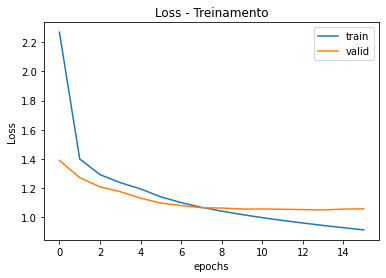

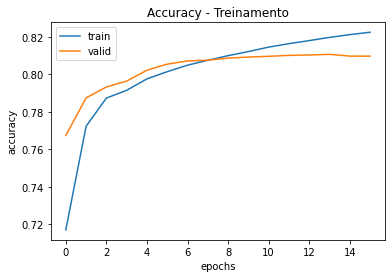

<Figure size 432x288 with 0 Axes>

In [32]:
# Gráfico da loss e da acurácia
import matplotlib.pyplot as plt 
plt.title('Loss - Treinamento')
plt.xlabel('epochs')
plt.ylabel('Loss')
if RUN_MODE:
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='valid')
else:
    plt.plot(history['loss'], label='train')
    plt.plot(history['val_loss'], label='valid')
plt.legend()
plt.show()
plt.clf()

plt.title('Accuracy - Treinamento')
plt.xlabel('epochs')
plt.ylabel('accuracy')
if RUN_MODE:
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
else:
    plt.plot(history['accuracy'], label='train')
    plt.plot(history['val_accuracy'], label='valid')
plt.legend()
plt.show()
plt.clf()

In [33]:
# Análise do série de test (y_test)
if RUN_MODE:
    model.evaluate([X_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0], y_test.shape[1],1)[:,1:])

In [34]:
# Carrega tokens serializados
with open('NMT_Etokenizer.pkl','rb') as f:
  vocab_size_source, Eword2index, reviewTokenizer = pkl.load(f)

with open('NMT_Mtokenizer.pkl', 'rb') as f:
  vocab_size_target, Mword2index, titleTokenizer = pkl.load(f)

with open('NMT_data.pkl','rb') as f:
  X_train, y_train, X_val, y_val = pkl.load(f)

In [35]:
Eindex2word = reviewTokenizer.index_word
Mindex2word = titleTokenizer.index_word

In [36]:
model_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 64)       2209152     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 60, 64), (No 33024       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [37]:
# encoder inference
encoder_inputs = model_loaded.input[0]  #loading encoder_inputs
encoder_outputs, state_h, state_c = model_loaded.layers[6].output #loading encoder_outputs

print(encoder_outputs.shape)

encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step ---
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_length_review,latent_dim)) # ---

# Get the embeddings of the decoder sequence
decoder_inputs = model_loaded.layers[3].output

print(decoder_inputs.shape)
dec_emb_layer = model_loaded.layers[5]

dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_lstm = model_loaded.layers[7]
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_layer = model_loaded.layers[8]
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])

concate = model_loaded.layers[9]
decoder_inf_concat = concate([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_dense = model_loaded.layers[10]
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

(None, 60, 64)
(None, None)


In [38]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = Mword2index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      physical_devices = tf.config.list_physical_devices('GPU') 
      tf.config.experimental.set_memory_growth(physical_devices[0], True)
      with tf.device('GPU:0'):
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
          break
        else:
          sampled_token = Mindex2word[sampled_token_index]

          if(sampled_token!='end'):
              decoded_sentence += ' '+sampled_token

              # Exit condition: either hit max length or find stop word.
              if (sampled_token == 'end' or len(decoded_sentence.split()) >= (26-1)):
                  stop_condition = True

          # Update the target sequence (of length 1).
          target_seq = np.zeros((1,1))
          target_seq[0, 0] = sampled_token_index

          # Update internal states
          e_h, e_c = h, c

    return decoded_sentence

In [39]:
Eindex2word = reviewTokenizer.index_word
Mindex2word = titleTokenizer.index_word

In [40]:
# Converte vetor em title
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=Mword2index['start']) and i!=Mword2index['end']):
        newString=newString+Mindex2word[i]+' '
    return newString
# Converte vetor em review
def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+Eindex2word[i]+' '
    return newString

In [41]:
X_test[0]

array([ 130,   10,  156,   92,   13, 1101,    6,   12,    4,   16,   31,
         58,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [42]:
len(X_test)

17517

In [43]:
# Predict
if RUN_MODE:
  dfResults =  pd.DataFrame(columns=['Review','Original','Predicted','NIST','BLEU','METEOR'])
  from tqdm.notebook import tqdm
  size = X_test
  with tqdm(total=len(size)) as pbar:  
    for i in range(len(size)):
      review = seq2text(X_test[i])
      original = seq2summary(y_test[i])
      predicted = decode_sequence(X_test[i].reshape(1,max_length_review))
      dfResults = dfResults.append({'Review': review, 'Original': original,'Predicted': predicted}, ignore_index=True)
      pbar.update(1)
    dfResults.to_pickle('dfResults.df')
else:
  dfResults =  pd.read_pickle('dfResults.df')

dfResults.to_csv('b2wCorpusFulldfResults.tsv', sep = '\t',index = False)


In [44]:
# Predict
if RUN_MODE:
  dfResults =  pd.DataFrame(columns=['Review','Original','Predicted','NIST','BLEU','METEOR'])
  from tqdm.notebook import tqdm
  size = X_test
  with tqdm(total=len(size)) as pbar:  
    for i in range(len(size)):
      review = seq2text(X_test[i])
      original = seq2summary(y_test[i])
      predicted = decode_sequence(X_test[i].reshape(1,max_length_review))
      dfResults = dfResults.append({'Review': review, 'Original': original,'Predicted': predicted}, ignore_index=True)
      pbar.update(1)
      print('predicted:',predicted)
    dfResults.to_picklpredictede('dfResults.df')
    
else:
  dfResults =  pd.read_pickle('dfResults.df')

dfResults.to_csv('b2wCorpusFulldfResults.tsv', sep = '\t',index = False)

In [45]:
# Checa o resultado do predict
dfResults.head()

,Review,Original,Predicted,NIST,BLEU,METEOR
0,para quem e tem parentes ou amigos que gostam ...,muito bom,gostei do produto,NaN,NaN,NaN
1,atendeu todas minhas expectativas qualidade ót...,americanas melhor loja,excelente,NaN,NaN,NaN
2,poderia ser maior principalmente no assento co...,tamanho,bom,NaN,NaN,NaN
3,isso é um descaso com o cliente já tem um mês ...,nunca mais compro nessa loja,nao recebi o produto,NaN,NaN,NaN
4,o produto atende ao que promete estou muito sa...,otimo produto,ótimo produto,NaN,NaN,NaN


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
No handles with labels found to put in legend.


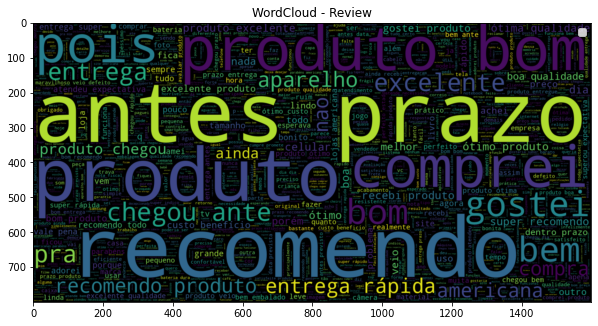

In [46]:
# WordCloud do Review
tokens = []
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
size = len(dfResults.index)
for i in range(size):
    text = dfResults.iloc[i].Review
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(tokens))
plt.title('WordCloud - Review')
plt.legend()
plt.imshow(wc , interpolation = 'bilinear')

No handles with labels found to put in legend.


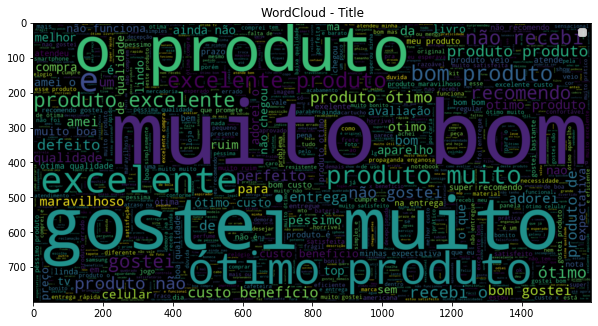

In [47]:
# WordCloud do do Title
plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(dfResults.Original))
plt.title('WordCloud - Title')
plt.legend()
plt.imshow(wc , interpolation = 'bilinear')

No handles with labels found to put in legend.


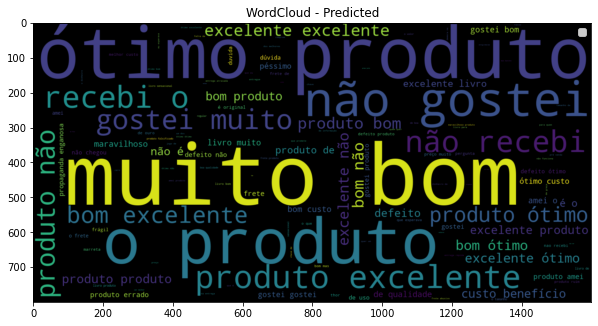

In [48]:
# WordCloud do Predicted (y_test)
plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(dfResults.Predicted))
plt.title('WordCloud - Predicted')
plt.legend()
plt.imshow(wc , interpolation = 'bilinear')

In [49]:
# Cálculo da métrica NIST
from tqdm.notebook import tqdm
size = len(dfResults.index)
with tqdm(total=size) as pbar:  
  for i in range(size):
    reference = dfResults.iloc[i].Original
    candidate = dfResults.iloc[i].Predicted
    if reference != '' and candidate != '':         
            nist = sentence_nist([reference.split()], candidate.split(),1)  
            dfResults.iloc[i,3] = nist
    pbar.update(1)


Métricas para o NIST

Minímo: 0.0
Média: 0.133
Máximo: 2.0
Média: Ponderada 0.066
Desvio Padrão: 0.329
% CV: 247.652  %



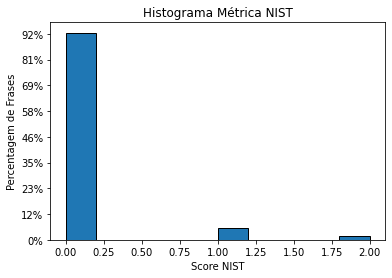

In [50]:
# Relatório do NIST
print("Métricas para o NIST\n")
data = dfResults[dfResults['NIST'].notna()]['NIST'].values
print("Minímo:", round(np.min(data),3))
m = np.mean(data)
print("Média:", round(m,3))
print("Máximo:", round(np.max(data),3))
print("Média: Ponderada", round(m/np.max(data),3))
sdev = round(np.std(data),3)
print("Desvio Padrão:", round(sdev,3))
cv = round((sdev/m)*100,3)
print("% CV:", cv, ' %\n')

aNIST = dfResults[dfResults['NIST'].notna()]['NIST'].values
WordsaNIST = np.round(aNIST.astype(np.double))

num_of_points = len(WordsaNIST)
data = WordsaNIST
fig, ax = plt.subplots()
ax.hist(data,  edgecolor='black')
ax.set_title("Histograma Métrica NIST")
ax.set_xlabel("Score NIST")
ax.set_ylabel("Percentagem de Frases")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(data)))
plt.show()

In [51]:
# Cáclculo da métrica BLEU
err = 0
from tqdm.notebook import tqdm
size = len(dfResults.index)
with tqdm(total=size) as pbar:  
  for i in range(size):
      reference = dfResults.iloc[i].Original
      candidate = dfResults.iloc[i].Predicted
      pbar.update(1)
      if reference != '' and candidate != '':
            cc = SmoothingFunction()
            dfResults.iloc[i,4] = sentence_bleu([reference.split()], candidate.split(),smoothing_function=cc.method1)


Métricas para o BLEU

Minímo: 0
Média: 0.046
Máximo: 1.0
Desvio Padrão: 0.121
% CV: 263.947  %



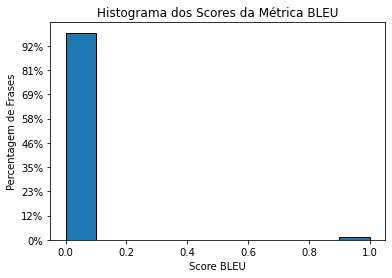

In [52]:
# Relatório do BLEU
print("Métricas para o BLEU\n")
data = dfResults[dfResults['BLEU'].notna()]['BLEU'].values
print("Minímo:", round(np.min(data),3))
m = np.mean(data)
print("Média:", round(m,3))
print("Máximo:", round(np.max(data),3))
sdev = round(np.std(data),3)
print("Desvio Padrão:", round(sdev,3))
cv = round((sdev/m)*100,3)
print("% CV:", cv, ' %\n')
aBLEU = dfResults[dfResults['BLEU'].notna()]['BLEU'].values
WordsaBLEU = np.round(aBLEU.astype(np.double))
num_of_points = len(WordsaBLEU)
num_of_bins = 11
data = WordsaBLEU
fig, ax = plt.subplots()
ax.hist(data, bins=[j/100 for j in range(0,110,10)], edgecolor='black')
ax.set_title("Histograma dos Scores da Métrica BLEU")
ax.set_xlabel("Score BLEU")
ax.set_ylabel("Percentagem de Frases")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(data)))
plt.show()

In [53]:
# Cálculo da métrica METEOR
err = 0
from tqdm.notebook import tqdm
size = len(dfResults.index)
with tqdm(total=size) as pbar:  
  for i in range(size):
    reference = dfResults.iloc[i].Original
    candidate = dfResults.iloc[i].Predicted
    if reference != '' and candidate != '':
            meteor = meteor_score([reference], candidate)  
            dfResults.iloc[i,5] = meteor

    pbar.update(1)

Métricas para o METEOR

Minímo: 0.0
Média: 0.107
Máximo: 0.992
Desvio Padrão: 0.218
% CV: 203.125  %



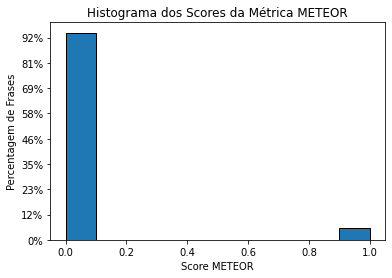

In [54]:
# Relatório do Meteor
print("Métricas para o METEOR\n")
data = dfResults[dfResults['METEOR'].notna()]['METEOR'].values
print("Minímo:", round(np.min(data),3))
m = np.mean(data)
print("Média:", round(m,3))
print("Máximo:", round(np.max(data),3))
sdev = round(np.std(data),3)
print("Desvio Padrão:", round(sdev,3))
cv = round((sdev/m)*100,3)
print("% CV:", cv, ' %\n')
aMETEOR = dfResults[dfResults['METEOR'].notna()]['METEOR'].values
WordsaMETEOR = np.round(aMETEOR.astype(np.double))
num_of_points = len(WordsaMETEOR)
num_of_bins = 11
data = WordsaMETEOR
fig, ax = plt.subplots()
ax.hist(data, bins=[j/100 for j in range(0,110,10)], edgecolor='black')
ax.set_title("Histograma dos Scores da Métrica METEOR")
ax.set_xlabel("Score METEOR")
ax.set_ylabel("Percentagem de Frases")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(data)))
plt.show()

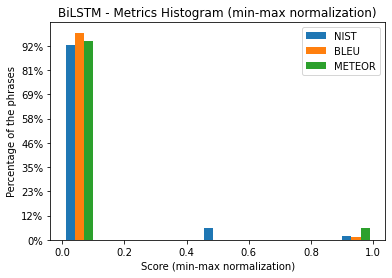

In [55]:
bins = np.linspace(0, 1, 10)
WordsaNISTh = WordsaNIST/np.max(WordsaNIST)
WordsaBLEUh = WordsaBLEU/np.max(WordsaBLEU)
WordsaMETEORh = WordsaMETEOR/np.max(WordsaMETEOR)
fig, ax = plt.subplots()
bins = np.linspace(0, 1, 10)
ax.hist((WordsaNISTh,WordsaBLEUh,WordsaMETEORh), bins,  label=('NIST','BLEU','METEOR'))
ax.legend(loc='upper right')
ax.set_title("BiLSTM - Metrics Histogram (min-max normalization)")
ax.set_xlabel("Score (min-max normalization)")
ax.set_ylabel("Percentage of the phrases")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(data)))
plt.show()

In [56]:
# Analise de Tamanho do Title e do Predicted
def dicionarios_size(dfResult):
    Review = []
    Original = []
    fcOriginal = []
    Predicted = []
    fcPredicted = []
    size = len(dfResult.index)
    for i in range(size):
        Review = Review + dfResult.iloc[i].Review.split()
        Original = Original + dfResult.iloc[i].Original.split()
        fcOriginal.append(len(dfResult.iloc[i].Original.split())) 
        Predicted = Predicted + dfResult.iloc[i].Predicted.split()
        fcPredicted.append(len(dfResult.iloc[i].Predicted.split()))
    return len(np.unique(Review)) , len(np.unique(Original)), len(np.unique(Predicted)), fcOriginal,fcPredicted

r, o, p, fco,fcp = dicionarios_size(dfResults)

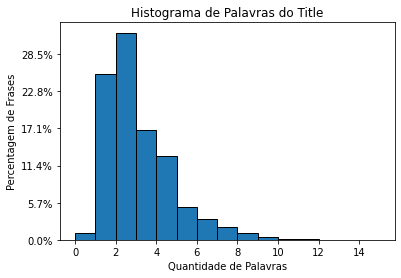

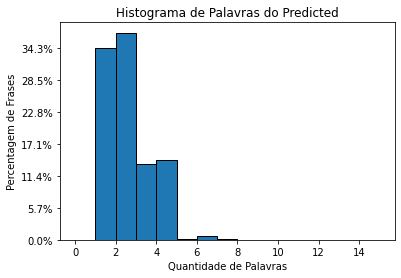


Tamanho de Dicionários
Review: 11914 palavras 
Title: 3100 palavras 
Predicted: 102 palavras

Métricas para o Title (em palavras)
Minímo: 0
Média: 2.632
Máximo: 11
Desvio Padrão: 1.647
% CV: 62.57  %

Métricas para o Predicted (em palavras)
Minímo: 1
Média: 2.117
Máximo: 11
Desvio Padrão: 1.096
% CV: 51.772  %

Diferença no tamanho do dicionário do Title e do Predicted: 2998.0 palavras ou 2939.2157 %
Diferença no tamanho médio entre as frases do Title e do Predicted: 0.5153 palavras ou 24.34 %
Diferença no % CV Máquina entre o Title e do Predicted: 10.798 % ou relativa: 20.8568 %



In [57]:
# Relatório das medidas de contagem de palabras
Words = fco
num_of_points = len(Words)
num_of_bins = 20 
data = Words
fig, ax = plt.subplots()
ax.hist(data, bins=[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15], edgecolor='black')
ax.set_title("Histograma de Palavras do Title")
ax.set_xlabel("Quantidade de Palavras")
ax.set_ylabel("Percentagem de Frases")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(data)))
plt.show()

Words = fcp
num_of_points = len(Words)
num_of_bins = 20 
data = Words
fig, ax = plt.subplots()
ax.hist(data, bins=[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15], edgecolor='black')
ax.set_title("Histograma de Palavras do Predicted")
ax.set_xlabel("Quantidade de Palavras")
ax.set_ylabel("Percentagem de Frases")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(data)))
plt.show()

print("\nTamanho de Dicionários")
print('Review: ' + str(r) + ' palavras \nTitle: ' + str(o) + ' palavras \nPredicted: ' + str(p)+ ' palavras')

print("\nMétricas para o Title (em palavras)")
print("Minímo:", round(np.min(fco),3))
m = np.mean(fco)
print("Média:", round(m,3))
print("Máximo:", round(np.max(fco),3))
sdev = round(np.std(fco),3)
print("Desvio Padrão:", round(sdev,3))
cvT = round((sdev/m)*100,3)
print("% CV:", cvT, ' %')

print("\nMétricas para o Predicted (em palavras)")
print("Minímo:", round(np.min(fcp),3))
m = np.mean(fcp)
print("Média:", round(m,3))
print("Máximo:", round(np.max(fcp),3))
sdev = round(np.std(fcp),3)
print("Desvio Padrão:", round(sdev,3))
cvP = round((sdev/m)*100,3)
print("% CV:", cvP, ' %\n')

print('Diferença no tamanho do dicionário do Title e do Predicted:',round(np.mean(o)-np.mean(p),4), 'palavras ou' , round((np.mean(o)-np.mean(p))/np.mean(p)*100,4),'%')
print('Diferença no tamanho médio entre as frases do Title e do Predicted:',round(np.mean(fco)-np.mean(fcp),4), 'palavras ou' , round((np.mean(fco)-np.mean(fcp))/np.mean(fcp)*100,4),'%')
print('Diferença no % CV Máquina entre o Title e do Predicted:',round(cvT-cvP,4), '% ou relativa:' , round((cvT-cvP)/cvP*100,4),'%\n')

In [58]:
# Exportação dos resultados do corpo de Teste (corpus, predicted e métricas)
dfResults.to_csv('b2wCorpusFulldfResults.tsv', sep = '\t',index = False)

In [59]:

runEnd = datetime.now()
runTime = (runEnd - runStart).total_seconds() / 60.0
print("Run time elapsed:",round(runTime,0),'minutes')


Run time elapsed: 10.0 minutes
